# Language Models

Language models (LMs) estimate the probability of different linguistic units: words, symbols, tokens, token sequences.\
A good Language Model assigns higher probability to textual fragments that are "more likely" to appear in a language.


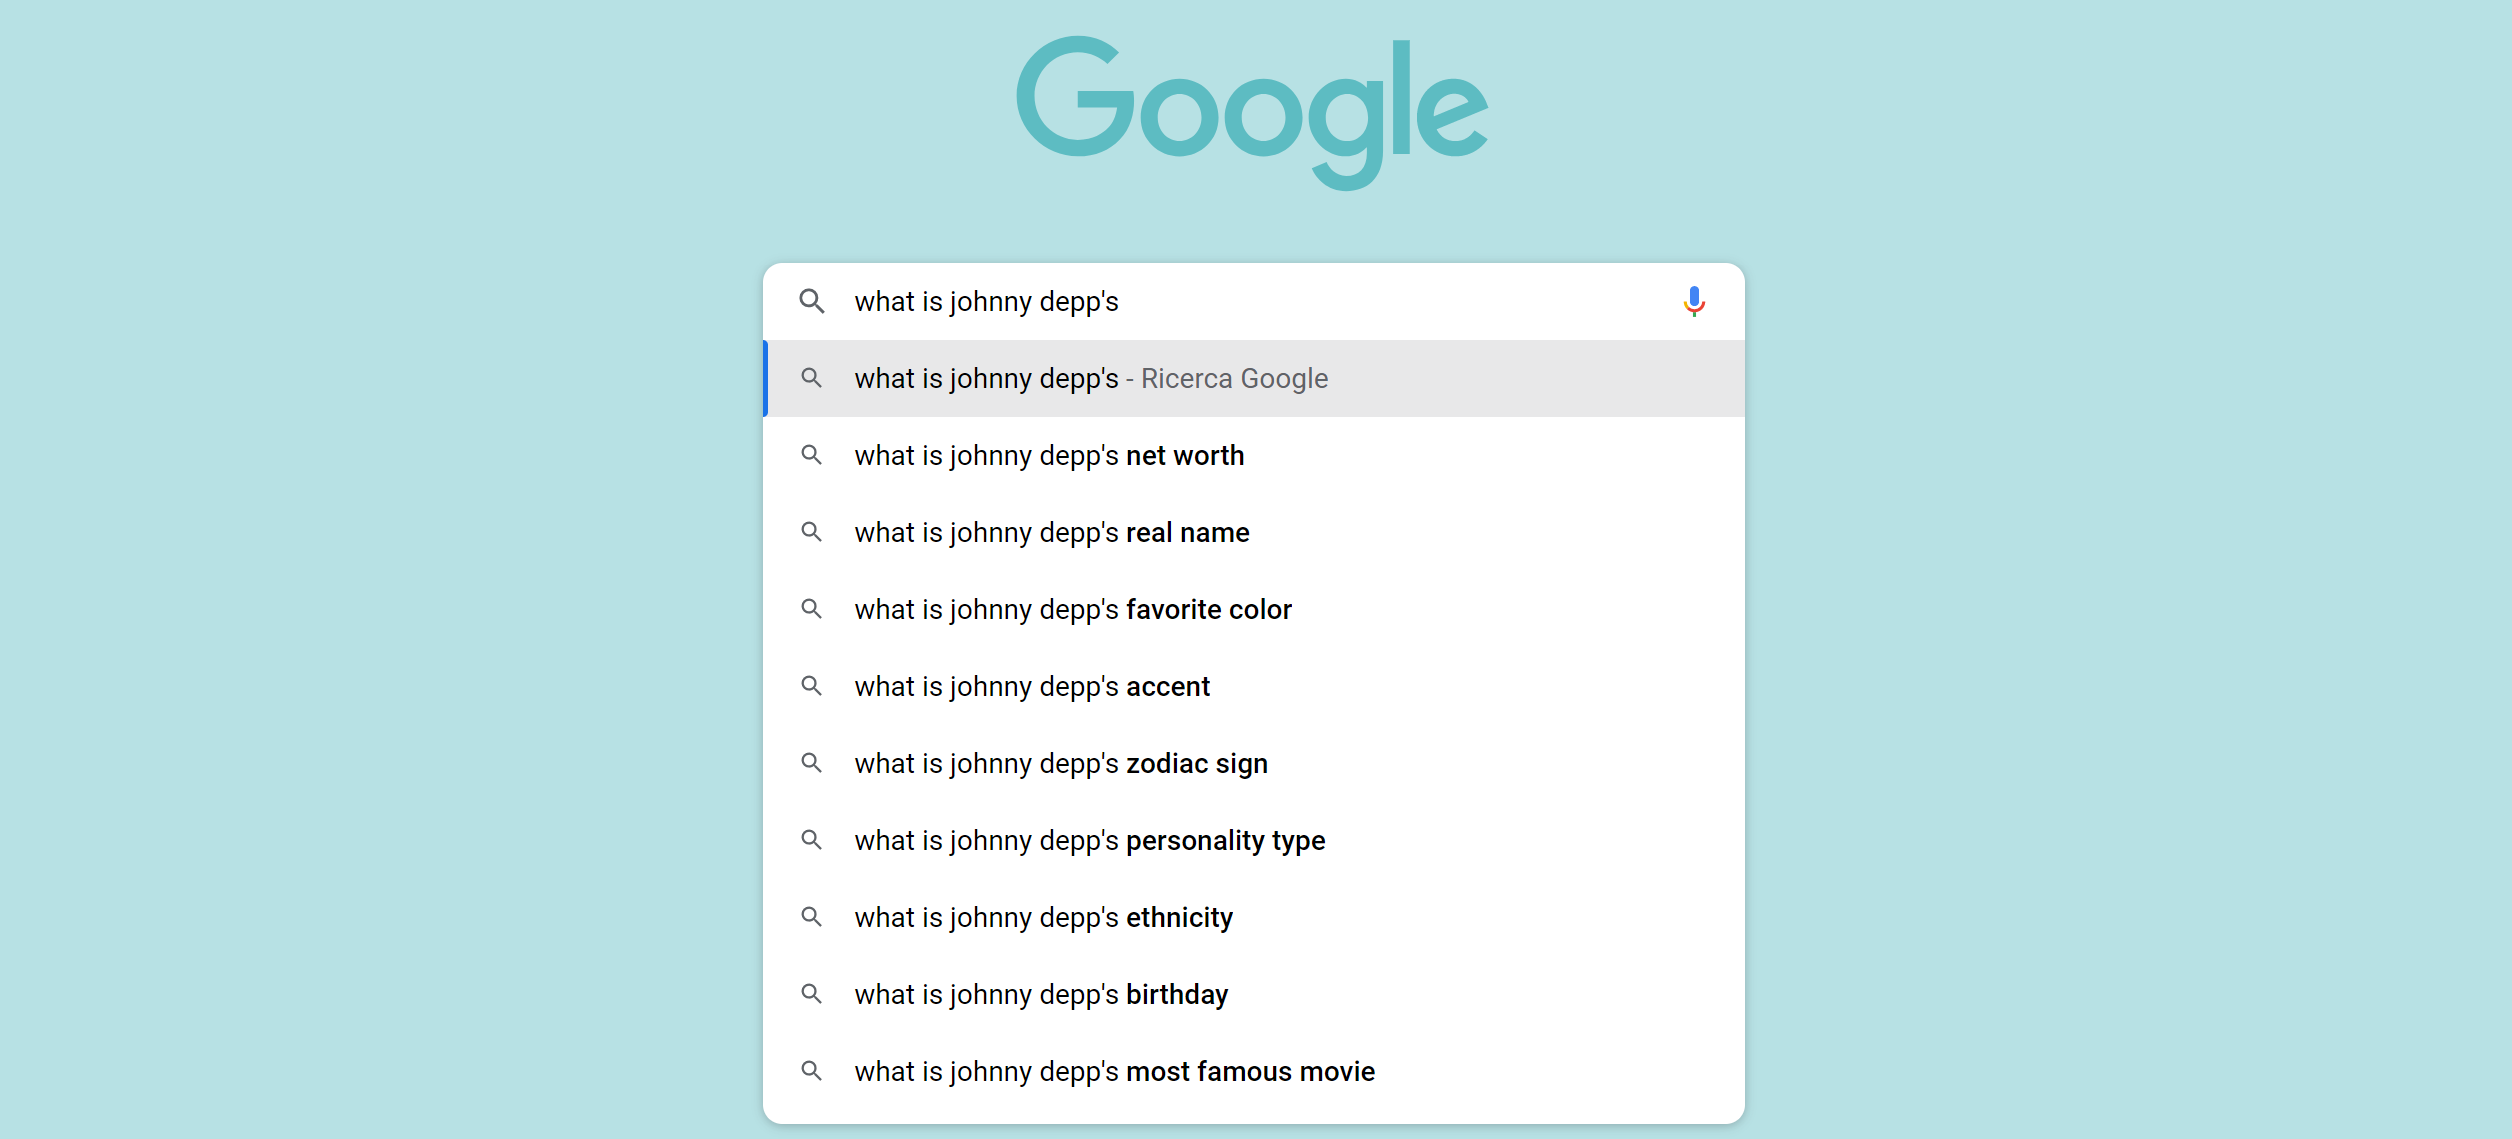

## Left-to-right modeling framework

$$
P\text{( I saw a fluffy cat )}
$$
    
To estimate the probability of a sentence in a language, we can simply use its frequency in a corpus.\
However, with this approach any sentence than never occured in our corpus, will receive zero probability.\
Instead, we use the chain rule to estimate the probability to observe a sequence of tokens in a specific order.\
The chain rule decomposes the probability of a text into conditional probabilities of each token given its previous context.\
By context we mean those words appearing to the left of the current word.

$$ P(\text{ I},\text{ saw},\text{ a},\text{ fluffy}, \text{ cat } ) = P(\text{ I }) · P(\text{ saw }|\text{ I } ) · P(\text{ a }| \text{ I, saw }) · P(\text{ fluffy } | \text{ I, saw, a } ) · P(\text{ cat } | \text{ I, saw, a, fluffy } ) $$

Question: How to compute conditional probabilities ?  



## N-gram Language Model

Estimates of conditional probabilities are based on counts from a text corpus.

$$ P(w_i| w_1, .., w_{i-1} ) = \frac{count (w_1, .., w_{i-1}, w_i)}{count( w_1, .., w_{i-1})}  $$

The key components of N-gram language model are Markov Property and smoothing.

#### Markov property (Independence assumption)
The n-gram model assumes that the probability of a word (gram) only depends on a fixed number of previous words.\
Thus, the model approximates the conditional probability of a word, conditioning on n - 1 previous words.\
For example, consider a 3-gram model :


$$ P(\text{ I},\text{ saw},\text{ a},\text{ fluffy}, \text{ cat } ) = P(\text{ I }) · P(\text{ saw }|\text{ I } ) · P(\text{ a }| \text{ I, saw }) · P(\text{ fluffy } | \text{ saw, a } ) · P(\text{ cat } | \text{ a, fluffy } ) $$


#### Smoothing
In case of zero count appearing at denominator or numerator, smoothing is used to redistribute probability mass among seen and unseen events. \
Avoid zeros in the numerator, by adding 1, or some small quantity to all counts, pretending to have seen all n-grams at least once.\
This technique is called laplace smoothing.



## Neural Language Model 

Neural LMs train a network to predict conditional probabilities of a token given its context.
* encode the context (previous words) into a vector representation
* from this representation predict the probability distribution for the next token.

A neural LM can be seen as a classifier: \
it classifies the context of a text into a number of classes equal to the number of tokens in the vocabulary.

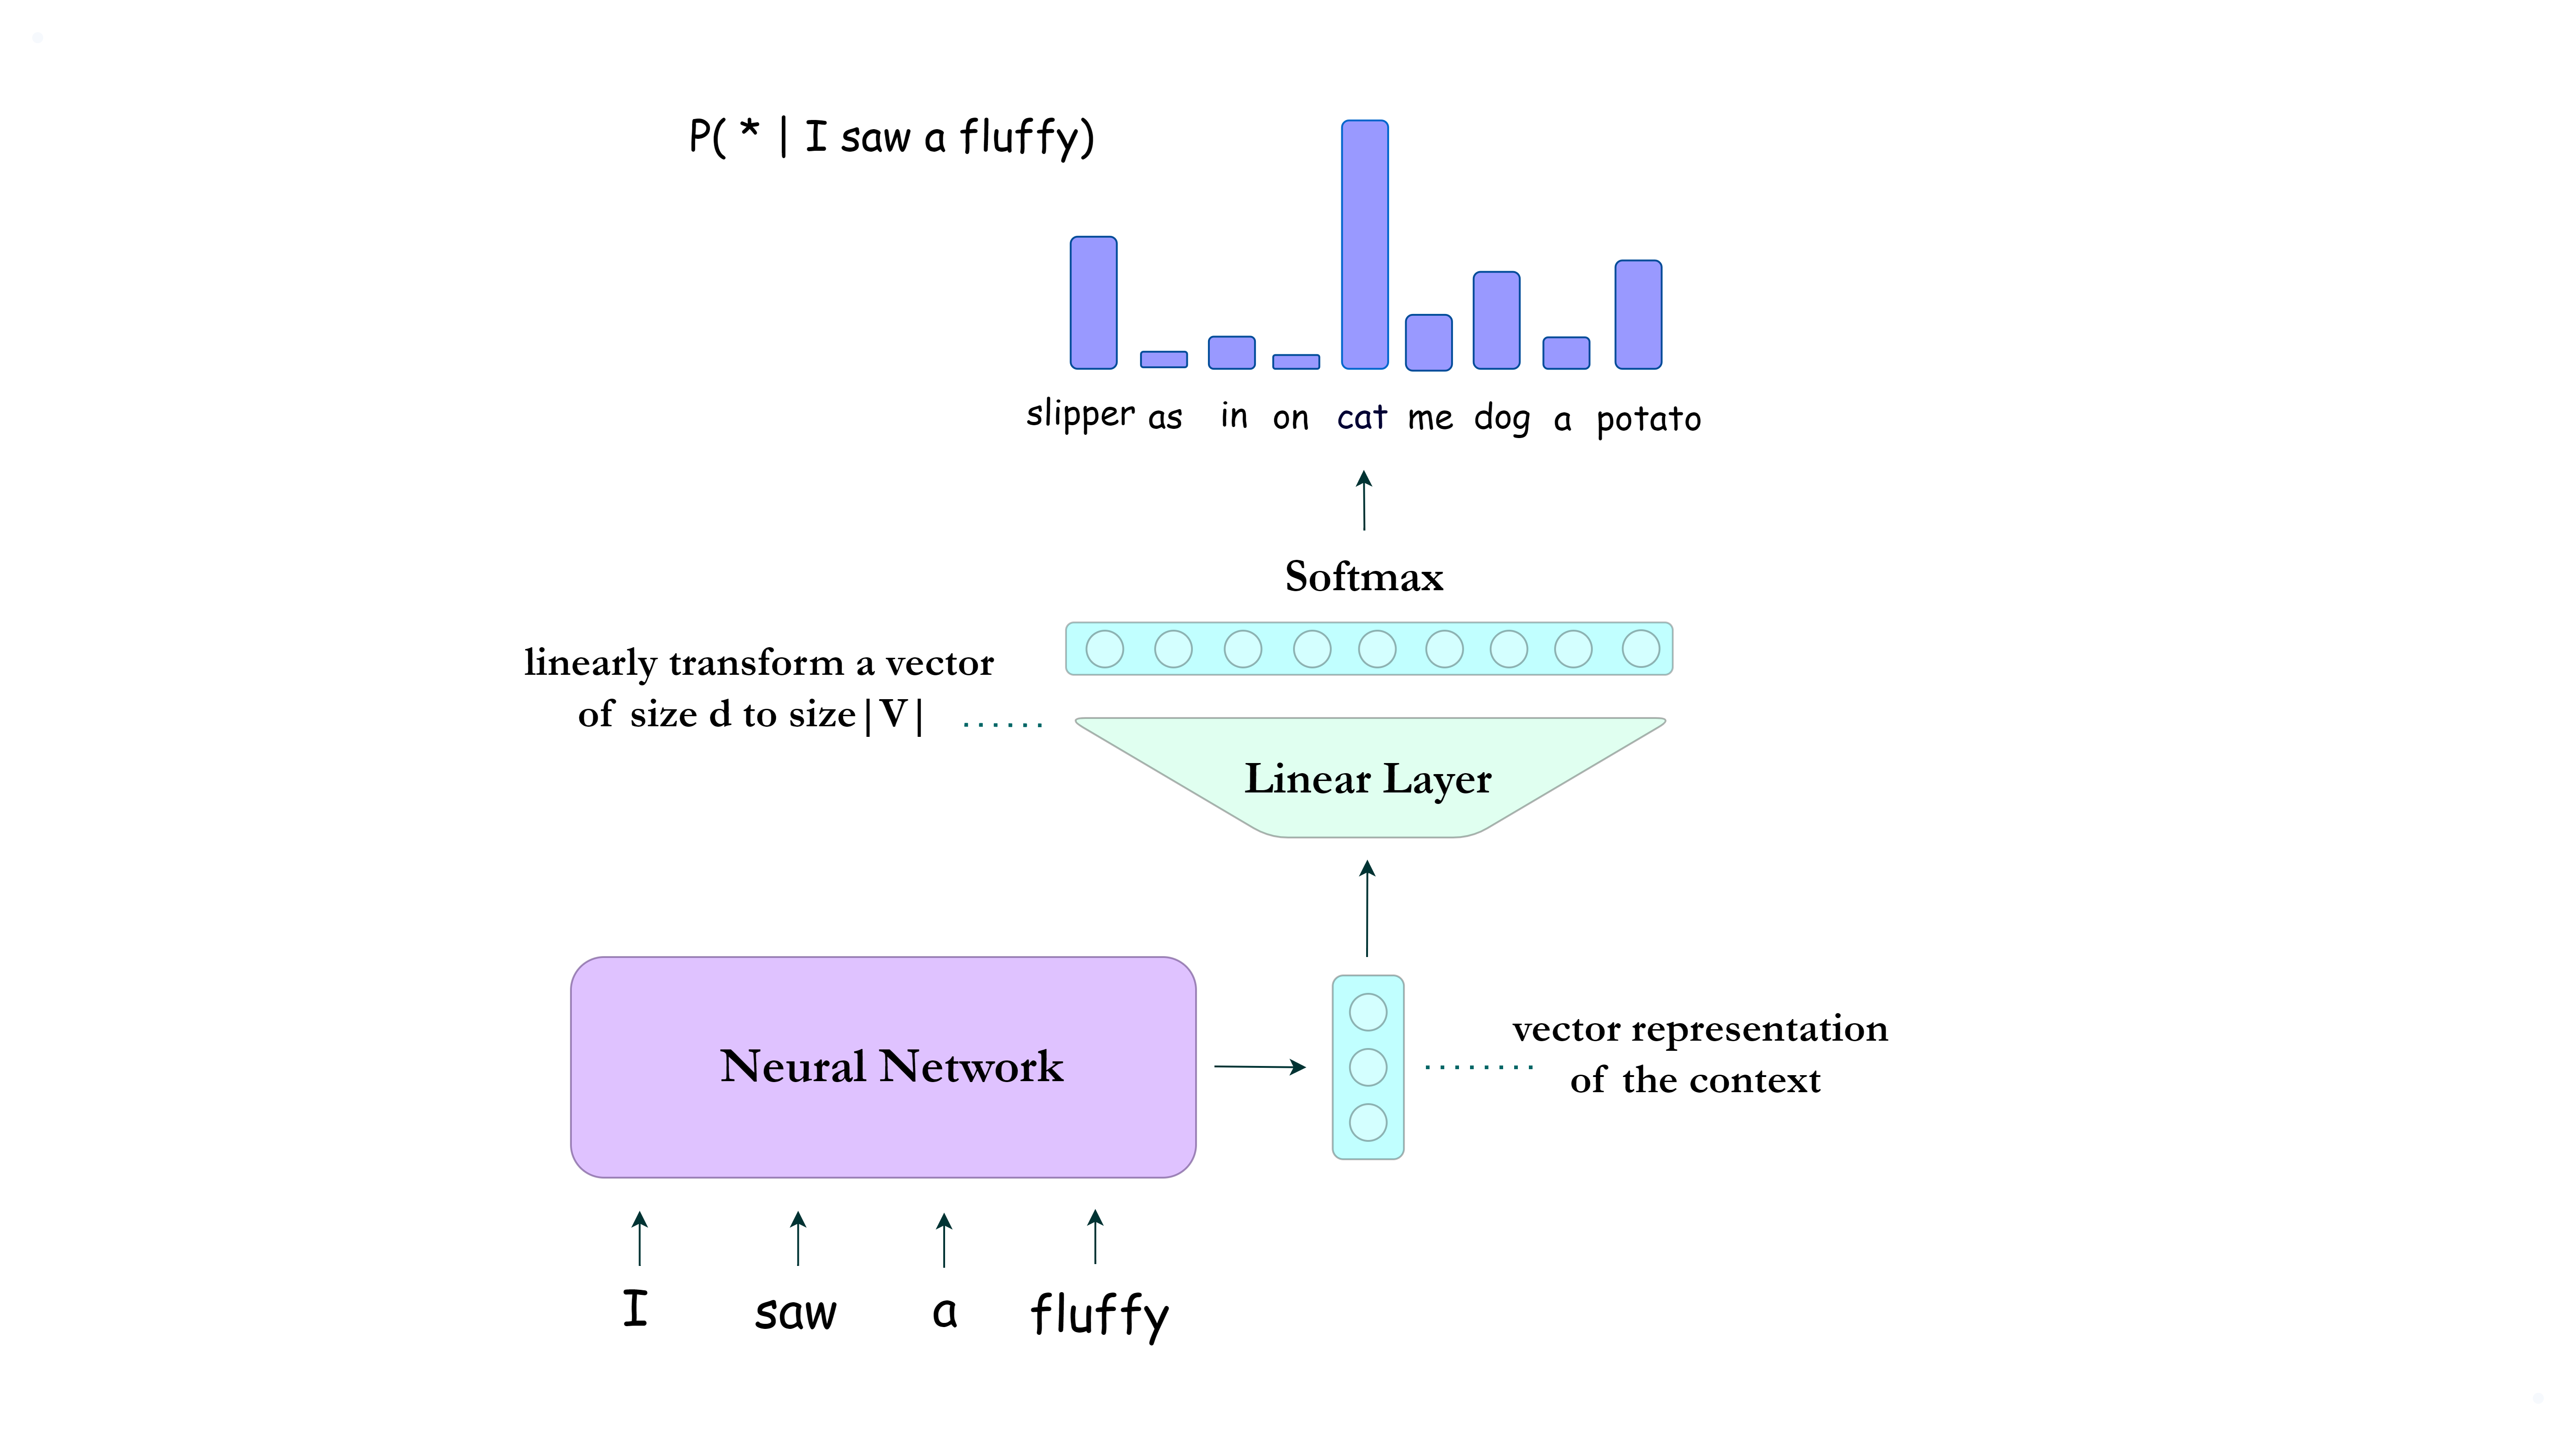

### How can we generate text with a LM ?
* step 0: start with a current context (called prefix)
* step 1: generate a probability distribution for the next token over all tokens in the vocabulary
* step 2: sample a token from the distribution
* step 4: add the token to prefix 
* step 5: repeat the previous steps

##  Model Shakespeare characters' language

Our corpus consists of 40,000 lines of Shakespeare from a variety of Shakespeare's plays.

In [1]:
import numpy as np
import re, nltk
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter, OrderedDict
from torchtext.vocab import vocab

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dashb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
with open(r"C:\Users\dashb\Downloads\Telegram Desktop\shakespeare_tiny.txt") as file:
    plays = file.read()
    
print(plays[522001:522700])


Yet 'banished'? Hang up philosophy!
Unless philosophy can make a Juliet,
Displant a town, reverse a prince's doom,
It helps not, it prevails not: talk no more.

FRIAR LAURENCE:
O, then I see that madmen have no ears.

ROMEO:
How should they, when that wise men have no eyes?

FRIAR LAURENCE:
Let me dispute with thee of thy estate.

ROMEO:
Thou canst not speak of that thou dost not feel:
Wert thou as young as I, Juliet thy love,
An hour but married, Tybalt murdered,
Doting like me and like me banished,
Then mightst thou speak, then mightst thou tear thy hair,
And fall upon the ground, as I do now,
Taking the measure of an unmade grave.

FRIAR LAURENCE:
Arise; one knocks; good Romeo, hide thy


Retrieve names for all characters appearing in the corpus.

In [29]:
characters = defaultdict(int)

for reply in plays.split("\n\n"):
    match = re.search(r"[A-Z]\w+( \w+)*:\n", reply)
    if match is not None:
        characters[match.group(0).strip(":\n")] += 1
        
characters = [name for name, freq in sorted(characters.items(), key=lambda x: x[1], reverse=True)]
print("Number of charaters in the dataset:", len(characters))
print("Names of the first 8 main characters in the Shakespeare plays:\n", characters[:8])

Number of charaters in the dataset: 271
Names of the first 8 main characters in the Shakespeare plays:
 ['GLOUCESTER', 'DUKE VINCENTIO', 'MENENIUS', 'ROMEO', 'CORIOLANUS', 'KING RICHARD III', 'ISABELLA', 'JULIET']


## <h6 style="text-align: center;"><b>Data preparation</b>

We split corpus into sentences using ``nltk.tokenize_sentence`` and filter for sentences longer than 3 tokens.\
Each sentence is tokenized with the help of ``nltk.tokenize_word`` method and \<eos\> token is appended to the end.


In [4]:
def tokenize_sentence(sentence):
    """ Clean and tokenize the sentence. """
    clean_sentence = re.sub("--", " ", sentence.strip())
    tokens = word_tokenize(clean_sentence)
    return tokens

In [5]:
sentences = []
for sentence in sent_tokenize(re.sub("\n", " ", plays)):
    tokenized_sent = tokenize_sentence(sentence.lower())
    if len(tokenized_sent) < 3:
        continue
    sentences.append(tokenized_sent + ["<eos>"])
    
print("Total number of training sentences: ", len(sentences))

Total number of training sentences:  10882


In [6]:
# example of the first sentence after tokenization
print(" ".join(sentences[0]))

first citizen : before we proceed any further , hear me speak . <eos>


## <h4 style="text-align: center;"><b>NGram modeling</b>

In [7]:
from nltk import bigrams, trigrams, ngrams

In [360]:
list(ngrams("Here me speek .".split(), n=3 , pad_left=True))

[(None, None, 'Here'),
 (None, 'Here', 'me'),
 ('Here', 'me', 'speek'),
 ('me', 'speek', '.')]

In [350]:
# build a trigram model

model = defaultdict(Counter)
for sentence in sentences:
    for w1, w2, w3 in ngrams(sentence, n=3, pad_left=True):
        model[(w1, w2)][w3] += 1

In [351]:
print(f"'juliet' follows 'romeo :' {model['romeo', ':']['juliet']} times")
print(f" {model[None, None]['juliet']} sentences start with 'juliet' ")

'juliet' follows 'romeo :' 2 times
 118 sentences start with 'juliet' 


In [352]:
# compute probabilities from counts

for w1_w2 in model:
    w1_w2_total_counts = float(model[w1_w2].total())
    for w3 in model[w1_w2]:
        probability = model[w1_w2][w3] / w1_w2_total_counts
        model[w1_w2][w3] = probability

In [353]:
model[None, None]['juliet']

0.010843594927403052

In [149]:
from nltk import pad_sequence

In [356]:
list(pad_sequence("hear me".split(),              # sequence to pad
                  n=3,                            # n is the degree of the ngrams
                  pad_left=True ,                 # if padding to the left
                  left_pad_symbol="<pad>"))       # padding symbol to use

['<pad>', '<pad>', 'hear', 'me']

In [289]:
class NGramModel(object):
    
    def __init__(self, n = 3):
        self.ngrams = defaultdict(Counter)
        self.n = n
        
    def count_ngrams(self, sentences):
        
        """ Collect ngram counts from corpus of sentences. """

        for sentence in tqdm(sentences):
            for ngram in ngrams(sentence, n=self.n, pad_left=True):
                prefix, next_word = ngram[:-1], ngram[-1]
                self.ngrams[tuple(prefix)][next_word] += 1
            

    def compute_log_prob(self, prefix):
        
        """ Compute log probabilities for a given prefix.
        Args:
            prefix List[str]: list of words
            
        Returns:
            dictinary of log probabilities : dict(tuple, float)
        
        """
        
        # if prefix is shorter than n-1 -> pad prefix to n-1 length
        prefix = tuple(pad_sequence(prefix, n=self.n-1 , pad_left=True))
        
        # if prefix is longer than n-1 -> take the last n-1 grams 
        prefix = prefix[:-self.n:-1][::-1]
        
        # counts for all words that might follow the prefix
        next_word_counts = self.ngrams[prefix] 
        
        # prefix is found among ngrams
        if len(next_word_counts)>0: 
            prefix_counts = self.ngrams[prefix].total()
            return {next_word: 
                    np.log(next_word_counts[next_word]) - np.log(prefix_counts) for next_word in next_word_counts} 
        
        # prefix never occured in training corpus
        else:
            return {}
        
    def sample_next(self, prefix):
        """ 
        Sample the next token for a given prefix according to the frequency learned from data.
        
        Args:
            prefix: List[str]
            
        Returns:
            next token: int
        
        """
        next_word_prob = self.compute_log_prob(prefix)
        if len(next_word_prob)>0:
            next_token, next_prob = next_word_prob.keys(), next_word_prob.values()
            end = np.random.choice(list(next_token), p = np.exp(list(next_prob)))
            return end
        return "<eos>"

In [292]:
def make_me_speak(name, max_len_text=1000):
    
    """ 
    Generate text for a given character.
    
    Args:
        name: str
        max_len_text: int
        
    Returns:
        generated_text: str
    """
    
    assert isinstance(name, str)
    prefix = name.lower().split()
        
    for i in range(max_len_text):
        next_word = model.sample_next(prefix)
        if next_word == "<eos>":
            break
        prefix += [next_word]
    
    return " ".join(prefix)

In [313]:
model = NGramModel(n=4)
model.count_ngrams(sentences)

  0%|          | 0/10882 [00:00<?, ?it/s]

In [315]:
model.compute_log_prob(["juliet"])

{':': -0.025752496102414923,
 ',': -4.07753744390572,
 'wills': -4.770684624465665}

In [319]:
model.sample_next(["romeo", ":"])

'give'

In [338]:
make_me_speak("romeo")

'romeo : o blessed heavens !'

## <h3 style="text-align: center;"><b>Neural language modeling</b>

## <h6 style="text-align: center;"><b>Build token-to-integer mapping</b>

In [7]:
UNK_index = 0
BOS_index = 1
EOS_index = 2

# build an ordered dictionary of word counts
token_counter = Counter()
for sentence in sentences:
    token_counter.update(sentence)

sorted_by_freq_tuples = token_counter.most_common()
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# create a mapping from words to integer ids
token2int = vocab(ordered_dict, min_freq=2, specials=['<unk>', '<bos>', '<eos>'])
token2int.set_default_index(UNK_index)

In [8]:
# encoding
[token2int[token] for token in 'romeo : o blessed heavens ! <eos>'.split()]

[114, 4, 56, 1096, 576, 20, 2]

In [9]:
# decoding
token2int.lookup_tokens([113, 3, 55, 1095, 575, 19, 1])

['see', ',', 'on', 'sentence', 'pluck', 'not', '<bos>']

## <h6 style="text-align: center;"><b>Encode and chunk the corpus</b>

In [10]:
from itertools import chain
encoded_corpus = []
for sentence in sentences:
    encoded_corpus.extend([BOS_index] + [token2int[token] for token in sentence])

In [11]:
" ".join([token2int.lookup_token(index) for index in encoded_corpus[:20]])

'<bos> first citizen : before we proceed any further , hear me speak . <eos> <bos> all : speak ,'

Clip the sequence length to 35, and split the encoded corpus in chunks of 35 tokens each.

In [12]:
seq_length = 35
training_chunks = [encoded_corpus[i:i+seq_length] for i in range(len(encoded_corpus)-seq_length)]

## <h6 style="text-align: center;"><b>Build training Dataset</b>

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

class ShakespearDataset(Dataset):
    def __init__(self, training_chunks):
        self.chunks = training_chunks
        
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, index):
        input_tensor = self.chunks[index][:-1]
        target_tensor = self.chunks[index][1:]
        return torch.LongTensor(input_tensor).to(device), torch.LongTensor(target_tensor).to(device)

In [20]:
batch_size = 20
train_data = ShakespearDataset(training_chunks)
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [21]:
input_batch, target_batch = next(iter(train_dl))
input_batch.shape, target_batch.shape

(torch.Size([20, 34]), torch.Size([20, 34]))

## <h6 style="text-align: center;"><b>Build RNN Language Model</b>

In [33]:
import torch.nn as nn

class RNNGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, num_layers, dropout):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = rnn_hidden_size
        self.num_layers = num_layers
        
        # embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_dim)
        
        # recurrent layer
        self.rnn = nn.GRU(input_size=embed_dim,
                          hidden_size=rnn_hidden_size,
                          num_layers=num_layers, 
                          dropout=dropout,
                          batch_first=True)
        
        # output linear layer
        self.decoder = nn.Linear(in_features=rnn_hidden_size,
                                 out_features=vocab_size)
        
        # regularization
        self.drop = nn.Dropout(dropout)
        
    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device)
            
        # emb with size (batch_size, seq_len, embed_dim)
        emb = self.drop(self.embedding(input))
        
        # output shape: (batch_size, seq_len, hidden_size)
        # hidden shape: (num_layers, batch_size, hidden_size)
        output, _ = self.rnn(emb, hidden)
        
        # decoded_output shape: (batch_size*seq_len, vocab_size)
        decoded_output = self.decoder(output)
        decoded_output = decoded_output.contiguous().view(-1, self.vocab_size)
        return decoded_output

In [34]:
vocab_size = len(token2int)
embed_dim = 100
hidden_size = 100
num_layers = 2
dropout_p = 0.2

model = RNNGenerator(vocab_size, embed_dim, hidden_size, num_layers, dropout_p)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

## <h6 style="text-align: center;"><b>Train RNN Language model</b>

In [35]:
num_iterations = 10000
for iteration in range(num_iterations):
    
    # step 0. get training data
    input_batch, target_batch = next(iter(train_dl))
    
    # step 1. zero gradients
    optimizer.zero_grad()
    
    # step 2. compute prediction
    prediction = model(input_batch)
    
    # step 3. compute the loss
    loss = loss_fn(prediction, target_batch.contiguous().view(-1))
    
    # step 4. compute gradients
    loss.backward()
    
    # step 5. update params
    optimizer.step()
    
    # step 6. reporting
    loss = loss.item() / (seq_length-1)
    
    if iteration % 500 == 0:
        print(f"Iteration {iteration} loss: {loss:.4f}")

Iteration 0 loss: 0.2565
Iteration 500 loss: 0.1540
Iteration 1000 loss: 0.1495
Iteration 1500 loss: 0.1423
Iteration 2000 loss: 0.1443
Iteration 2500 loss: 0.1377
Iteration 3000 loss: 0.1450
Iteration 3500 loss: 0.1409
Iteration 4000 loss: 0.1316
Iteration 4500 loss: 0.1296
Iteration 5000 loss: 0.1414
Iteration 5500 loss: 0.1275
Iteration 6000 loss: 0.1336
Iteration 6500 loss: 0.1305
Iteration 7000 loss: 0.1307
Iteration 7500 loss: 0.1318
Iteration 8000 loss: 0.1280
Iteration 8500 loss: 0.1314
Iteration 9000 loss: 0.1220
Iteration 9500 loss: 0.1328


The output of the model at each time stap is the prediction vector, which we turn into probability distribution with softmax layer.\
We then use ``torch.multinomial()`` sampling function to sample from the predicted distribution.\
This function selects an index with probability proportional to the probability at that index.

In [76]:
import torch.nn.functional as F
def sample_and_decode(model, max_seq_len=15, prefix=None):
    model.eval()
    with torch.no_grad():
        if prefix is None:
            prefix = "<bos>"
            
        indices = [token2int[token] for token in prefix.split()]
        x_t = torch.LongTensor(indices).to(device)
        hidden = torch.zeros(num_layers, 1, hidden_size).to(device)
        for t in range(max_seq_len):
            emb_t = model.embedding(x_t.view(1, -1))
            output, hidden = model.rnn(emb_t, hidden)
            logits = model.decoder(hidden[-1])
            probs = F.softmax(logits, dim=-1)
            sampled_index = torch.multinomial(probs, num_samples=1)
            indices.append(sampled_index.item())
            x_t = sampled_index
            if sampled_index.item() == EOS_index:
                break
    return " ".join(token2int.lookup_tokens(list(indices)))

In [119]:
sample_and_decode(model, prefix = "juliet")

"juliet : you 'll desire thee ! <eos>"